# Transport Mode Classification using BiLSTM (RNN)
To better understand the code, check out `./prep_files/biLSTM_transport_classification.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from src.engine import biLSTM_engine
from src.model_transportMode import BiLSTMNetwork
from src.plot import plot_history, plot_endgame_history
from src.dataset import TransportModeDataset

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, random_split

Computing class weights

In [2]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights)
del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]
Class weights: tensor([0.6685, 0.7598, 6.0714, 1.4663, 0.8401, 1.3729, 0.8195, 0.8317],
       device='cuda:0')


Original coarse labels are shown below. During preprocessing, the Null class (`0.0`), was dropped and with the remaining, I substracted `1` from the labels so that it would start from `0`.

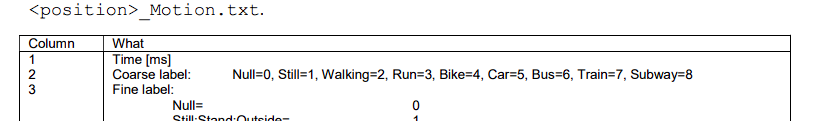

In [3]:
base_dir = './data/lstm_features_labels/'

train_datasets = TransportModeDataset(base_dir, mode='train')
val_test_datasets = TransportModeDataset(base_dir, mode='valid')

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [4]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

### 1st Run with 1st Config

In [5]:
Fst_config= {'optimizer': 'adamw', 'lr': 0.007696965501070433, 'scheduler': 'exp', 
             'gamma': 0.9318166309092948, 'patience': 10, 'epochs': 1200, 
             'batch_size': 64, 'weight_decay': 0.07563306484196267, 'hidden_size': 300, 
             'num_layers': 1, 'dropout': 0.494696861183782}

In [6]:
batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [7]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697) #drop is technically == 0 since n_layers == 1
optimizer = optim.AdamW(model.parameters(), lr=0.00769697, weight_decay=0.0756331)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.931817)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [8]:
engine = biLSTM_engine(model, optimizer, scheduler, criterion, device)

In [9]:
firstRun_hist = engine.train_validation(train_dl, valid_dl, epochs=100, save_path='./model_checkpoint/run1_transpMode_BiLSTM_chkpt.pth')

np.save('./model_checkpoint/run1_transpMode_BiLSTM_history.npy', np.array(firstRun_hist))

   Epoch [1/100], Train Loss: 1.3762, Train Accuracy: 42.13%, Val Loss: 1.2007, Val Accuracy: 49.90%
   Epoch [2/100], Train Loss: 1.1691, Train Accuracy: 51.23%, Val Loss: 1.1444, Val Accuracy: 52.18%
   Epoch [3/100], Train Loss: 1.1178, Train Accuracy: 53.51%, Val Loss: 1.0328, Val Accuracy: 56.90%
   Epoch [4/100], Train Loss: 1.1338, Train Accuracy: 53.39%, Val Loss: 1.2138, Val Accuracy: 48.56%
   Epoch [5/100], Train Loss: 1.0899, Train Accuracy: 54.73%, Val Loss: 1.0583, Val Accuracy: 56.71%
   Epoch [6/100], Train Loss: 1.0507, Train Accuracy: 56.39%, Val Loss: 1.0358, Val Accuracy: 57.90%
   Epoch [7/100], Train Loss: 0.9951, Train Accuracy: 58.28%, Val Loss: 0.9348, Val Accuracy: 60.29%
   Epoch [8/100], Train Loss: 0.8853, Train Accuracy: 62.47%, Val Loss: 0.8691, Val Accuracy: 62.90%
   Epoch [9/100], Train Loss: 0.8302, Train Accuracy: 64.79%, Val Loss: 0.9988, Val Accuracy: 55.66%
   Epoch [10/100], Train Loss: 0.8115, Train Accuracy: 65.80%, Val Loss: 0.8005, Val Accura

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plot_history(firstRun_hist)

### 2nd Run with 1st Config
Uses normalized class_weights and gradient clipping

In [5]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights)
del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]
Class weights: tensor([0.0521, 0.0592, 0.4732, 0.1143, 0.0655, 0.1070, 0.0639, 0.0648],
       device='cuda:0')


In [6]:
Fst_config= {'optimizer': 'adamw', 'lr': 0.007696965501070433, 'scheduler': 'exp', 
             'gamma': 0.9318166309092948, 'patience': 10, 'epochs': 1200, 
             'batch_size': 64, 'weight_decay': 0.07563306484196267, 'hidden_size': 300, 
             'num_layers': 1, 'dropout': 0.494696861183782}

In [7]:
batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [8]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697) #drop is technically == 0 since n_layers == 1
optimizer = optim.AdamW(model.parameters(), lr=0.00769697, weight_decay=0.0756331)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.931817)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [9]:
engine = biLSTM_engine(model, optimizer, scheduler, criterion, device)

In [10]:
secondRun_hist = engine.train_validation(train_dl, valid_dl, epochs=100, save_path='./model_checkpoint/run2_transpMode_BiLSTM_chkpt.pth')

np.save('./model_checkpoint/run2_transpMode_BiLSTM_history.npy', np.array(secondRun_hist))

   Epoch [1/100], Train Loss: 1.3652, Train Accuracy: 42.31%, Val Loss: 1.1483, Val Accuracy: 51.25%
   Epoch [2/100], Train Loss: 1.1060, Train Accuracy: 53.37%, Val Loss: 1.0636, Val Accuracy: 55.00%
   Epoch [3/100], Train Loss: 0.9890, Train Accuracy: 57.84%, Val Loss: 0.9931, Val Accuracy: 58.68%
   Epoch [4/100], Train Loss: 0.8897, Train Accuracy: 62.20%, Val Loss: 0.8287, Val Accuracy: 64.23%
   Epoch [5/100], Train Loss: 0.8073, Train Accuracy: 66.04%, Val Loss: 0.7883, Val Accuracy: 66.14%
   Epoch [6/100], Train Loss: 0.7710, Train Accuracy: 67.58%, Val Loss: 0.7750, Val Accuracy: 68.14%
   Epoch [7/100], Train Loss: 0.7358, Train Accuracy: 69.01%, Val Loss: 0.7709, Val Accuracy: 68.54%
   Epoch [8/100], Train Loss: 0.7114, Train Accuracy: 69.87%, Val Loss: 0.7323, Val Accuracy: 70.17%
   Epoch [9/100], Train Loss: 0.6775, Train Accuracy: 71.34%, Val Loss: 0.7032, Val Accuracy: 71.60%
   Epoch [10/100], Train Loss: 0.6554, Train Accuracy: 72.29%, Val Loss: 0.6770, Val Accura

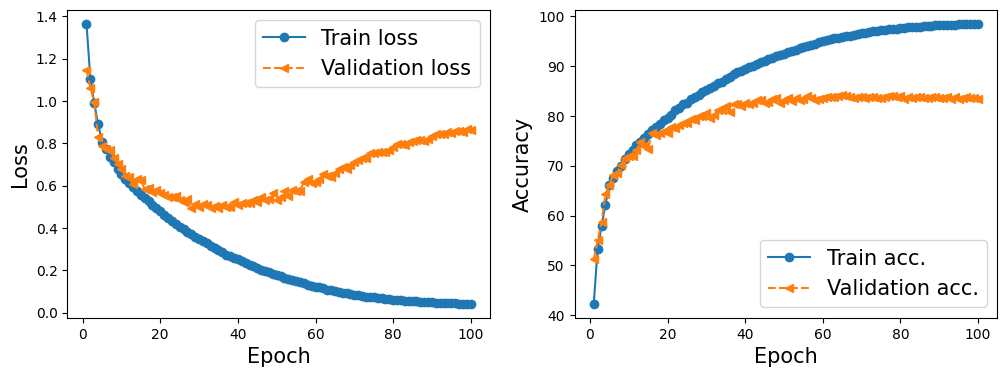

In [11]:
plot_history(secondRun_hist)

I believe the model at epoch 40 will give a good fit.

In [12]:
tempHist = secondRun_hist[0][:45], secondRun_hist[1][:45], secondRun_hist[2][:45], secondRun_hist[3][:45]

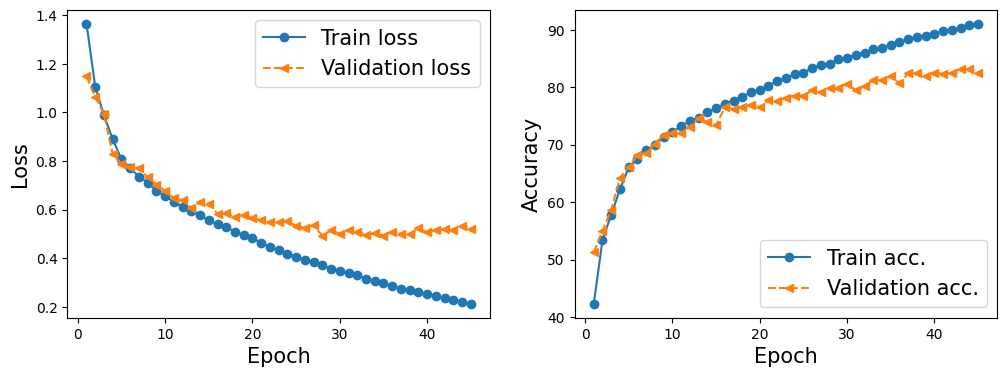

In [13]:
plot_history(tempHist)

Although this looks good, the 1st run had a slightly lesser loss at around the 40th epoch.

In [14]:
checkpoint = torch.load('./model_checkpoint/run2_transpMode_BiLSTM_chkpt.pth_epoch_40.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
engine = biLSTM_engine(model, optimizer, scheduler, criterion, device)

engine.test(test_dl)

Test Loss: 0.4858, Test Accuracy: 81.92%


(0.48576374843225373, 81.92354263968171)

#### 3rd Run: 2nd Config (1st Run)

In [ ]:
Snd_config= {'optimizer': 'adamw', 'lr': 0.005198989965043782, 'scheduler': 'ReduceLROnPlateau', 
             'gamma': 0.9383597426554285, 'patience': 5, 'epochs': 50, 'batch_size': 64, 
             'weight_decay': 0.008375293519355285, 'hidden_size': 300, 'num_layers': 1, 
             'dropout': 0.618753235646235}

In [ ]:
batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.618753235646235) #drop is technically == 0 since n_layers == 1
optimizer = optim.AdamW(model.parameters(), lr=0.005198989965043782, weight_decay=0.008375293519355285)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,factor=0.9383597426554285)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [ ]:
engine = biLSTM_engine(model, optimizer, scheduler, criterion, device)

In [ ]:
thirdRun_hist = engine.train_validation(train_dl, valid_dl, epochs=80, save_path='./model_checkpoint/run3_transpMode_BiLSTM_chkpt.pth')

np.save('./model_checkpoint/run23_transpMode_BiLSTM_history.npy', np.array(thirdRun_hist))

In [ ]:
plot_history(thirdRun_hist)